## Goals:

- Talk about different model fit metrics
- Talk about different choice rules (Softmax, epsilon-greedy)

##### Why do we need different model fit metrics than the summed squared error (SSE)?

- We see in the example at the end of notebook 2 that many different values of alpha all give the same (minimum) model error. We might want more precision in the model prediction to arbitrate between these different optimal alphas, which we can achieve by predicting _probability distributions_ instead of _point predictions_ from the model and from those probability distributions computing the likelihood of an observed data point.
- Many choice models simply don't provide a point prediction, but only a probability distribution. E.g. DDM, common choice rules in RL. Precise error is in that case _harder_ to compute than the likelihood of an observation.
- Likelihood will allow us to express model fit as a probability. This is useful for Bayesian inference, where we want to be able to say e.g. what the likelihood of the data given the model is (i.e. the probability of observing exactly this data if your model were true). We can then integrate this with a prior probability that our model is true and make more informed inferences.
- Models that produce probability distributions can account for noise/exploration/non-deterministic choice in datasets. This is adaptive in artifical agents!
- (You can _convert_ SSE into likelihood, but only under the assumption that the errors are normally distributed.)

In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Writing choice rules

In [36]:
def greedy(utilities, params = []):
    
    choice = np.where(utilities == np.max(utilities))[0][0]
    
    return choice

In [37]:
def e_greedy(utilities, epsilon):
    
    random_number = np.random.rand()
    
    if random_number < epsilon:
        # Choose randomly
        choice = np.random.randint(0,2)
    else:
        # Choose deterministically
#         choice = np.where(utilites == np.max(utilities))
        choice = greedy(utilities)
    
    return choice

In [ ]:
def softmax(utilities, beta):
    # Beta is sometimes called 'inverse temperature' or 'explore parameter'
    
    # Version for choice A only => then prob_B will be 1 - prob_A
    prob_A = (np.exp(utilities[0] * beta) /
              (np.exp(utilities[0] * beta) + np.exp(utilities[1] * beta)))
    
    # General version (this works too, try it out!)
    probs = (np.exp(np.multiply(utilities, beta)) /
             (np.sum(np.exp(np.multiply(utility, beta))))
    
    random_number = np.random.rand()
    if random_number < prob_A:
        choice = 0
    
    return choice

##### Simulate some data for each choice rule

(0, 1)

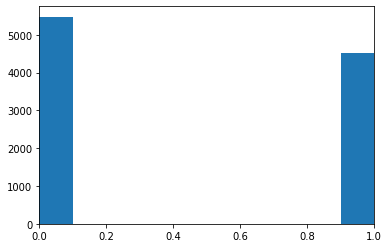

In [40]:
model = e_greedy
utilities = [6, 5.9] # just randomly chosen numbers
choices = []
epsilon = .9
for trial in range(10000):
    choice = model(utilities, epsilon)
    choices.append(choice)
plt.hist(choices);
plt.xlim([0,1])

## Prepare for next time:

1. Check that the softmax works! Try it out, visualize it.
2. Simulate choice data from the softmax model. What happens when the value difference of A and B increases or decreases?

## Also include in next session:

1. How to determine the likelihood of a dataset (as opposed to a single data point).
2. Talk about log-likelihood and why we use it.

## Session after that:

1. Find maximum-likelihood parameters for a model using gradient descent algorithms (based on SSE or LL)
2. Model comparison using AIC and BIC
3. Posterior predictive checks (no model is accurate!)

## Then:

1. Summarize what we've seen so far. Take a step back and talk about why it's useful what we've done and what we're still lacking.
2. Model / parameter recovery

## Functions from before

##### Choice models

In [2]:
def inequity_aversion_greedy(params, offer):
    
    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = [offer, 0]
    inequities = [(100-offer)-offer, 0]
    utilities = payoffs - np.multiply(params[0],inequities)
    choice = np.where(utilities == np.max(utilities))[0][0]

    return choice

In [3]:
def random_model(params, offer):
    
    choice = np.random.randint(0,2)
    
    return choice

##### Simulation code

In [4]:
def simulate_model(model, data_to_simulate, params = None):
    
    # Input variables: ...asdoaijsoiajc
    
    # Create output dataframe
    simulation_results = data_to_simulate.copy()
    
    # Loop over trials and simulate each trial
    for trial in data_to_simulate['trial']:
        offer = data_to_simulate.loc[data_to_simulate['trial']==trial, 'offer'].values[0]
        predicted_choice = model(params, offer)
        # store in output dataframe:
        simulation_results.loc[data_to_simulate['trial']==trial,'choice'] = predicted_choice
        
    return simulation_results

In [5]:
def plot_simulation(simulated_sub_data):
    
    fig = sns.scatterplot(data = simulated_sub_data, x = 'offer', y = 'choice')
    
    return fig

## Plan

1. Think about how to define 'model fit', i.e. when is a model good?
2. Computing model fit for a given model
3. Comparing model fit across participants and models

## Load some data

In [6]:
data_dir = '/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial/Data/Joey'

In [7]:
data = pd.read_csv(data_dir + '/Study1_UG_Data.csv')
data = data[['sub','trial','unfairness','choice']]
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


## 1.How to define model fit?

Let's start with a metric of model fit that you might know from regression: the sum of squared error (SSE).

## Compute model fit for our two models

- Step 1: plot a model + some data to see how well they overlap
- Step 2: compute the model fit

In [8]:
# Load data for a subject
sub = 20
sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
sub_data.head()

,trial,offer,choice
380,1,30,0
381,2,45,0
382,3,20,1
383,4,40,0
384,5,40,0


##### Visualize predictions of random model

[(-0.1, 1.1),
 Text(0, 0.5, 'choice'),
 Text(0.5, 0, 'offer'),
 Text(0.5, 1.0, 'SIMULATION')]

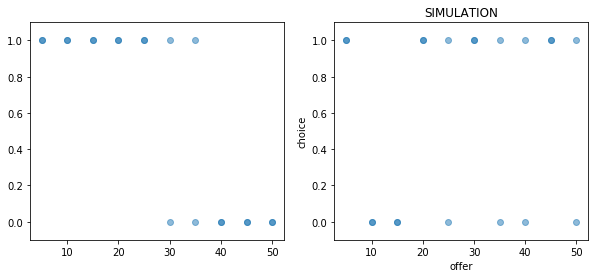

In [9]:
# Make a figure with two axes
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [10,4])

# Plot data
axes[0].scatter(x = sub_data['offer'], y = sub_data['choice'], alpha = .5)
axes[0].set(ylim = [-.1,1.1])

# Simulating the model
data_to_simulate = sub_data.copy()
simulated_data = simulate_model(random_model, data_to_simulate)

# Plot the model
axes[1].scatter(x = simulated_data['offer'], y = simulated_data['choice'], alpha = .5)
axes[1].set(title = 'SIMULATION', xlabel = 'offer', ylabel = 'choice', ylim = [-.1,1.1])

##### Compute model fit for random model

Sum of squared error = 10


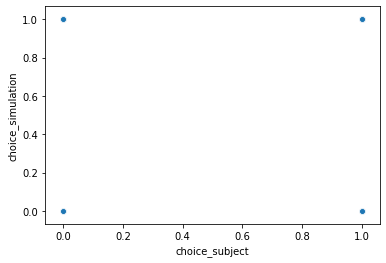

In [10]:
# Model fit = sum of squared errors

# First merge the two dataframes to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
total_data

# So first compute errors:
errors = total_data['choice_subject'] - total_data['choice_simulation']
errors

# Compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

sns.scatterplot(data = total_data, x = 'choice_subject', y = 'choice_simulation')

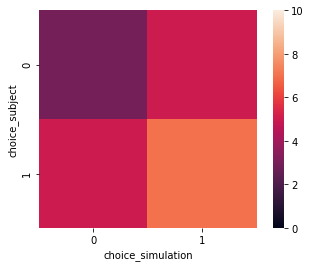

In [14]:
confusion_matrix = (total_data[['choice_subject','choice_simulation','trial']]
                    .groupby(['choice_subject','choice_simulation']).count()
                    .reset_index().pivot(index='choice_subject', columns = 'choice_simulation', values = 'trial'))
sns.heatmap(confusion_matrix, square = True, vmin = 0, vmax = 10)

In [15]:
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

10 hits


##### Compute model fit for inequity aversion model

In [16]:
simulated_data = simulate_model(inequity_aversion, data_to_simulate, [2])

In [17]:
# Model fit = sum of squared errors

# First merge the two dataframes to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
total_data

# So first compute errors:
errors = total_data['choice_subject'] - total_data['choice_simulation']
errors

# Compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

# Compute number of hits
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

Sum of squared error = 2
18 hits


In this case, the SSE and the number of hits are perfectly correlated (hits = 20 - SSE), so we can pick just one as our objective function (the measure of model fit).

##### Compute the model fit for many different values of alpha

In [46]:
range_of_alphas = np.arange(0,10,.1)

model_results = pd.DataFrame(columns=['alpha','hits'])

for alpha in range_of_alphas:
    
    # Simulate the model
    simulated_data = simulate_model(inequity_aversion, data_to_simulate, [alpha])
    
    # Merge observed and simulated data
    total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
    
    # Compute hits
    total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
    hits = np.sum(total_data['correct'])
    
    # Store result
    tmp = pd.DataFrame([[alpha,hits]], columns=model_results.columns)
    model_results = model_results.append(tmp)

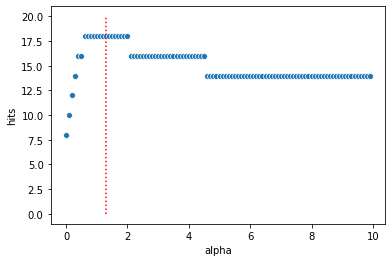

In [47]:
sns.scatterplot(data = model_results, x = 'alpha', y = 'hits')
best_alpha = model_results.query('hits == %i'%np.max(model_results.hits))['alpha'].mean()
plt.plot([best_alpha, best_alpha], [0,20], 'r:')

This plot shows you the value of alpha where you get the maximum number of hits, i.e. the best 'model fit'!

## Fitting the model for different subjects

In [60]:
def subject_fit(subject_data, model, min_alpha, max_alpha, alpha_step):
    
    range_of_alphas = np.arange(min_alpha, max_alpha, alpha_step)

    model_results = pd.DataFrame(columns=['alpha','hits'])

    for alpha in range_of_alphas:

        # Simulate the model
        simulated_data = simulate_model(model, subject_data, [alpha])

        # Merge observed and simulated data
        total_data = subject_data.merge(simulated_data,
                            on = ['trial','offer'], suffixes = ['_subject', '_simulation'])

        # Compute hits
        total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
        hits = np.sum(total_data['correct'])

        # Store result
        tmp = pd.DataFrame([[alpha,hits]], columns=model_results.columns)
        model_results = model_results.append(tmp)
    
    # Last step: select the best alpha
    best_hits = np.max(model_results['hits'])
    best_alphas = model_results.query('hits == %i'%best_hits)['alpha'].values
    best_alpha = np.mean(best_alphas)
    
    return best_alpha, best_hits, total_data, model_results

In [61]:
# Load data for a subject
sub = 20
sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
sub_data.head()

,trial,offer,choice
380,1,30,0
381,2,45,0
382,3,20,1
383,4,40,0
384,5,40,0


In [62]:
best_alpha, best_hits, total_data, model_results = subject_fit(sub_data, inequity_aversion, 0, 10, .1)

##### Loop over subjects

In [68]:
model_fits = pd.DataFrame(columns=['subject','best_alpha','hits'])
for sub in np.arange(1,21):
    print(sub, end = ', ')
    # Load data for a subject
    sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
    sub_data.head()
    # Fit model
    best_alpha, best_hits, total_data, model_results = (
        subject_fit(sub_data, inequity_aversion, 0, 10, .1))
    # Store
    tmp = pd.DataFrame([[sub, best_alpha, best_hits]], columns=model_fits.columns)
    model_fits = model_fits.append(tmp).reset_index(drop=True)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

In [69]:
model_fits

,subject,best_alpha,hits
0,1,0.00,20
1,2,0.50,17
2,3,0.00,20
3,4,0.65,18
4,5,0.25,19
5,6,0.45,20
6,7,0.10,20
7,8,0.00,20
8,9,0.45,20
9,10,0.00,20


In [77]:
np.max(model_fits['best_alpha'])

1.6

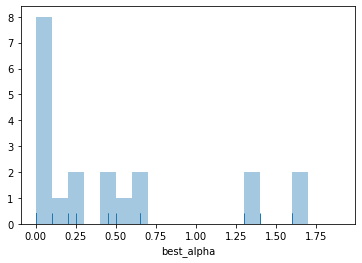

In [83]:
# Plot 1: distribution of alphas
sns.distplot(model_fits['best_alpha'], bins = np.arange(0, 2, .1), rug = True, kde = False)

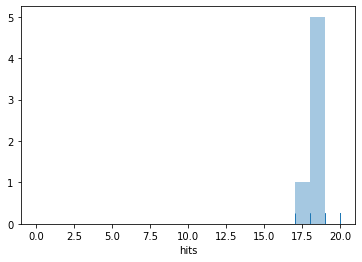

In [82]:
sns.distplot(model_fits['hits'], bins = np.arange(0, 20), kde = False, rug = True)